In [2]:
!git clone https://github.com/FleshRazer/F22-Introduction-to-Machine-Learning.git

Cloning into 'F22-Introduction-to-Machine-Learning'...
remote: Enumerating objects: 118, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 118 (delta 31), reused 90 (delta 18), pack-reused 0
Receiving objects: 100% (118/118), 1.97 MiB | 17.27 MiB/s, done.
Resolving deltas: 100% (31/31), done.


### Lab-3 : Self-Practice

#### In this week, your self-practice task will consist to analyze the impact of class imballance on the performance of the logistic regression model.

#### Class imbalance is very common in real life. For example, in a classification problem to predict whether a person has a certain very rare disease, the dataset will always contain more negative samples than positive ones. This situation can have a significant impact on the performance of the model. You will analyze this situation in the case of the Titanic dataset used in the lab.

### 1. Load the titanic dataset and <b>PLOT</b> the proportion of positive and negative samples (survived vs non survived)

In [3]:
# Load the dataset and plot (barplot) proportion of each class

import pandas as pd

data = pd.read_csv('F22-Introduction-to-Machine-Learning/Lab-3/titanic.csv')
data = data.drop('name', axis='columns')

data.head(5)

,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,1,1,female,29.00,0,0,211.3375,S
1,1,1,male,0.92,1,2,151.5500,S
2,0,1,female,2.00,1,2,151.5500,S
3,0,1,male,30.00,1,2,151.5500,S
4,0,1,female,25.00,1,2,151.5500,S


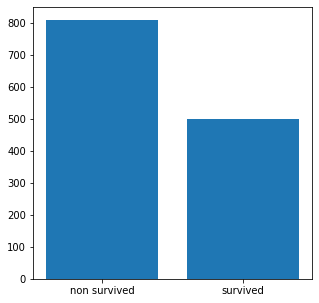

In [4]:
import matplotlib.pyplot as plt

label = ['non survived', 'survived']
height = [data.loc[lambda df: df['survived'] == 0, 'survived'].count(),
          data.loc[lambda df: df['survived'] == 1, 'survived'].count()]

plt.figure(figsize=(5, 5))
plt.bar(label, height)
plt.show()

#### Preprocess the data as it has been done in the lab, feel free to adapt

In [5]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline


numeric_features = ['age', 'sibsp', 'parch', 'fare']
numeric_transformer = make_pipeline(
    SimpleImputer(strategy='median'),
    MinMaxScaler(),
)

categorical_features = ['embarked', 'sex', 'pclass']
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(),
)

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features),
)

preprocessor.fit_transform(data).shape

(1309, 12)

## 2. Impact of class imballance. 
##### Now, you will `artificially` imbalance the dataset. From the original dataset, create different dataset with the following class representations (drop samples from one class): 
##### 1. 20% vs 80%
##### 2. 30% vs 70%
##### 3. 40% vs 60%

## Split each data into train and test set as in the lab; train logistic regression model for each setting and report (PLOT) the accuracy, precision, and recall of each model

data_2t8 height[0].frac=0.8002 height[1].frac=0.1998
data_3t7 height[0].frac=0.7004 height[1].frac=0.2996
data_4t6 height[0].frac=0.6000 height[1].frac=0.4000


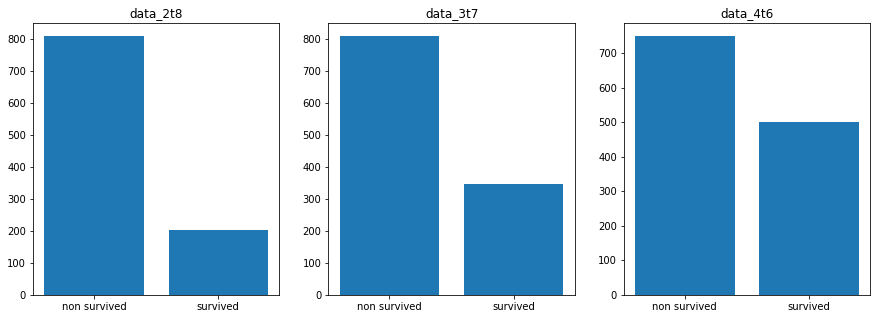

In [6]:
# Balancing dataset
s_df = data.loc[lambda df: df['survived'] == 0, :]  # survived
d_df = data.loc[lambda df: df['survived'] == 1, :]  # non survived

data_2t8 = d_df.sample(2 * s_df.shape[0] // 8).append(s_df)
data_3t7 = d_df.sample(3 * s_df.shape[0] // 7).append(s_df)
data_4t6 = s_df.sample(6 * d_df.shape[0] // 4).append(d_df)
dfs = {'data_2t8': data_2t8, 'data_3t7': data_3t7, 'data_4t6': data_4t6}

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (name, df) in enumerate(dfs.items()):
    label = ['non survived', 'survived']
    height = [df.loc[lambda df: df['survived'] == 0, 'survived'].count(),
              df.loc[lambda df: df['survived'] == 1, 'survived'].count()]
    
    axes[i].set_title(name)
    axes[i].bar(label, height)

    # Validate fractions
    print(f'{name} height[0].frac={height[0] / sum(height):.4f} '
          f'height[1].frac={height[1] / sum(height):.4f}')

fig.show()

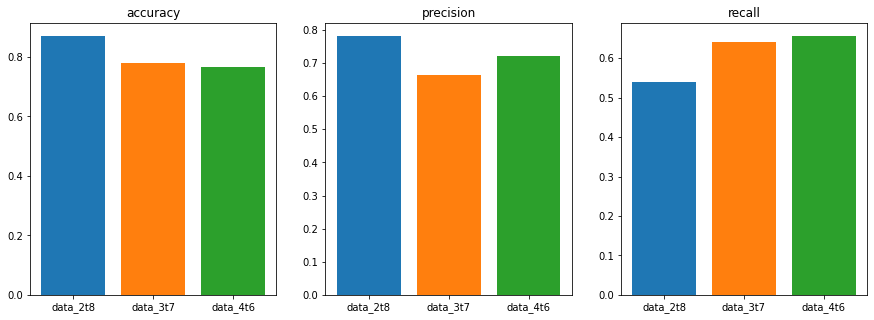

In [8]:
# Estimating accuacy, precision, and recall using cross_val_score

from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression


fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].set_title('accuracy')
axes[1].set_title('precision')
axes[2].set_title('recall')

pipeline = make_pipeline(preprocessor, LogisticRegression())
for name, df in dfs.items():
    X = df.drop('survived', axis='columns')
    y = df.loc[:, 'survived']

    accr_scores = cross_val_score(pipeline, X, y, cv=10, scoring='accuracy')
    prec_scores = cross_val_score(pipeline, X, y, cv=10, scoring='precision')
    recl_scores = cross_val_score(pipeline, X, y, cv=10, scoring='recall')

    axes[0].bar(name, mean(accr_scores))
    axes[1].bar(name, mean(prec_scores))
    axes[2].bar(name, mean(recl_scores))

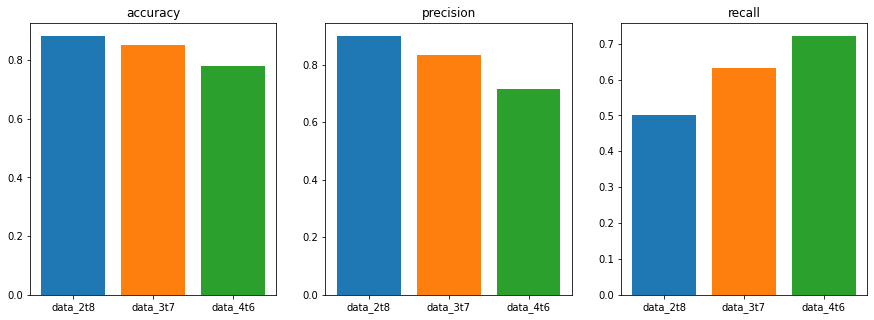

In [9]:
# Estimating accuacy, precision, and recall using sklearn.metrics

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].set_title('accuracy')
axes[1].set_title('precision')
axes[2].set_title('recall')

dfs_test_pred = {}

pipeline = make_pipeline(preprocessor, LogisticRegression())
for name, df in dfs.items():
    X = df.drop('survived', axis='columns')
    y = df.loc[:, 'survived']
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    dfs_test_pred[name] = (y_test, y_pred)

    axes[0].bar(name, accuracy_score(y_test, y_pred))
    axes[1].bar(name, precision_score(y_test, y_pred))
    axes[2].bar(name, recall_score(y_test, y_pred))

## 3. Analyse the class-wise accuracy. 
#### For each model, plot (bar plots) the class-wise accuracy, i.e., the accuracy for each class.

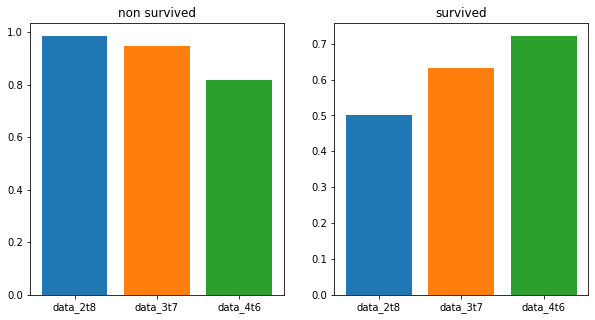

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].set_title('non survived')
axes[1].set_title('survived')

for name, (y_test, y_pred) in dfs_test_pred.items():
    s_true = 0
    s_total = 0
    d_true = 0
    d_total = 0

    for y_test_val, y_pred_val in zip(y_test, y_pred):
        if y_test_val == 0:
            if y_pred_val == 0:
                d_true += 1
            d_total += 1
        elif y_test_val == 1:
            if y_pred_val == 1:
                s_true += 1
            s_total += 1
    
    # y_test_d = y_test.loc[lambda df: df[0] == 0, :]
    # print(type(y_pred))
    
    axes[0].bar(name, d_true / d_total)
    axes[1].bar(name, s_true / s_total)
    

## 4. Report 
### Write a small report (few sentences) to discuss from your analysis, the impact of class imballance on logistic model's performance 

`Write your report here`